This project is a Image classification model build on **Convolutional Neural networks**.

This '[Fruits-360](https://www.kaggle.com/moltean/fruits)' dataset was taken from the Kaggle.

This dataset contains 90483 images of fruits and vegetables.

# Importing Required Libraries

In [2]:
import os                                       # For listing classes of my dataset directory
import torch                                           
import torchvision
import torch.nn as nn
import torch.nn.functional as F                 # For using some functions like cross_entropy() and etc
import matplotlib.pyplot as plt                 # For plotting the accuracy and loss of the model
from torch.utils.data import random_split       # For splitting dataset into training and validation datasets
from torchvision import transforms as ts        # For transforming image dataset like scaling, converting to tensors, etc.
from torchvision.datasets import ImageFolder    # For creating an image folder from a dataset directory using transforms
from torchvision.transforms import ToTensor     # For converting image dataset to tensors
from torch.utils.data.dataloader import DataLoader   # For accessing dataset in iterative batches and with shufflung, etc.
from torchvision.utils import make_grid         # For making a grid of images from the dataset

<IPython.core.display.Javascript object>

# Data Preprocessing

In [3]:
dataset_url = 'https://www.kaggle.com/moltean/fruits'
Dataset_dir = '../input/fruits/fruits-360'
classes = os.listdir(Dataset_dir+'/Training')
print(classes)
print(len(classes))

['Apple Golden 3', 'Cocos', 'Pitahaya Red', 'Huckleberry', 'Pear Forelle', 'Strawberry Wedge', 'Mango', 'Maracuja', 'Avocado', 'Apple Golden 1', 'Blueberry', 'Nut Forest', 'Rambutan', 'Salak', 'Plum', 'Pineapple', 'Cucumber Ripe 2', 'Cantaloupe 1', 'Tomato Maroon', 'Beetroot', 'Strawberry', 'Banana Lady Finger', 'Cherry Wax Yellow', 'Pear Stone', 'Grape White 2', 'Tomato 3', 'Pineapple Mini', 'Tomato 4', 'Tomato Cherry Red', 'Pepper Orange', 'Pear 2', 'Pear Abate', 'Kiwi', 'Dates', 'Grapefruit White', 'Pepper Red', 'Apple Red Delicious', 'Cherry Wax Red', 'Mulberry', 'Grape White 3', 'Peach Flat', 'Clementine', 'Potato White', 'Onion Red', 'Tangelo', 'Mango Red', 'Tomato 1', 'Peach 2', 'Corn', 'Nut Pecan', 'Avocado ripe', 'Apple Red 1', 'Pepper Yellow', 'Nectarine Flat', 'Tomato 2', 'Orange', 'Hazelnut', 'Potato Red Washed', 'Tomato Yellow', 'Peach', 'Grape White 4', 'Banana Red', 'Physalis', 'Raspberry', 'Fig', 'Grape Blue', 'Corn Husk', 'Apple Golden 2', 'Cherry 1', 'Grapefruit Pink'

In [4]:
transform = ts.Compose([ts.Resize((50,50)),
                        ts.RandomHorizontalFlip(),
                        ts.ToTensor(),
                        ts.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [5]:
dataset = ImageFolder(Dataset_dir+'/Training',transform)
test_ds = ImageFolder(Dataset_dir+'/Test',transform)
len(dataset)

67692

In [6]:
torch.manual_seed(13)
val_size = 13500
train_size = len(dataset)-val_size
train_ds, val_ds = random_split(dataset, [train_size,val_size])

In [7]:
image, label = dataset[100]
print(image.shape, label)

torch.Size([3, 50, 50]) 0


Label:  Apple Golden 1 (2)


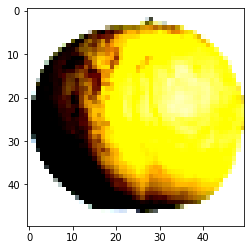

In [8]:
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

show_image(*dataset[1000])

In [9]:
batch_size = 128
train_dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

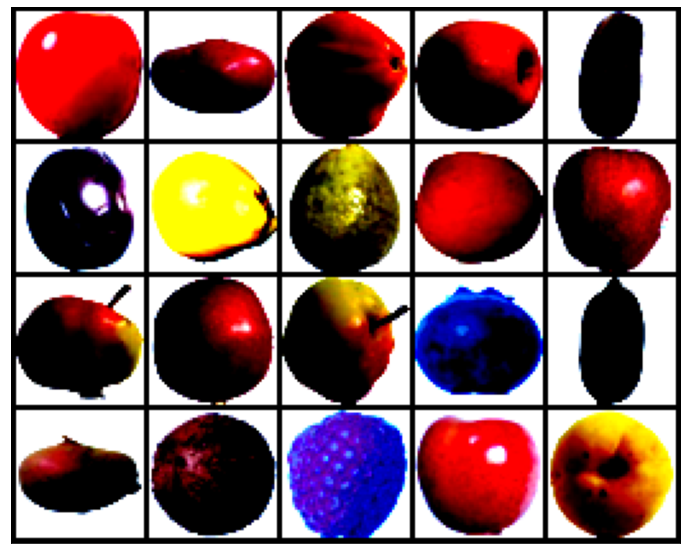

In [10]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:20], nrow=5).permute(1, 2, 0))
        break
show_batch(train_dl)

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

# Convolutional Neural Network Model

In [12]:
class FruitsCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 50, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(50, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 25 x 25

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 12 x 12

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 6 x 6

            nn.Flatten(), 
            nn.Linear(512*6*6, 2048),  
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 131))
        
    def forward(self, xb):
        return self.network(xb)

In [13]:
model = FruitsCnnModel()
model

FruitsCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(50, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten()
    (16): Linear(in_features=18432, out_features=2048, bias=True)
    (17): ReLU()
    (18): Linear(in_features=2048, out_featur

# Transfering Model to GPU Device

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [18]:
model = to_device(FruitsCnnModel(), device)

# Training the Model

In [17]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 4.875632286071777, 'val_acc': 0.007597663905471563}]

In [20]:
epochs = 10
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.Adam

In [21]:
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
               grad_clip=grad_clip, 
               weight_decay=weight_decay, opt_func=opt_func)

Epoch [0], last_lr: 0.00028, train_loss: 1.6971, val_loss: 0.2624, val_acc: 0.9196
Epoch [1], last_lr: 0.00076, train_loss: 0.2776, val_loss: 0.1184, val_acc: 0.9623
Epoch [2], last_lr: 0.00100, train_loss: 0.1362, val_loss: 0.0902, val_acc: 0.9711
Epoch [3], last_lr: 0.00095, train_loss: 0.0493, val_loss: 0.0518, val_acc: 0.9826
Epoch [4], last_lr: 0.00081, train_loss: 0.0520, val_loss: 0.0211, val_acc: 0.9955
Epoch [5], last_lr: 0.00061, train_loss: 0.0190, val_loss: 0.0006, val_acc: 0.9999
Epoch [6], last_lr: 0.00039, train_loss: 0.0007, val_loss: 0.0000, val_acc: 1.0000
Epoch [7], last_lr: 0.00019, train_loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000
Epoch [8], last_lr: 0.00005, train_loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000
Epoch [9], last_lr: 0.00000, train_loss: 0.0000, val_loss: 0.0000, val_acc: 1.0000


# Data visualization of Loss and Accuracy

In [22]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

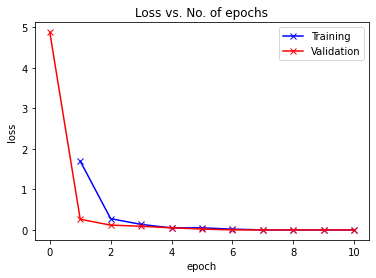

In [23]:
plot_losses(history)

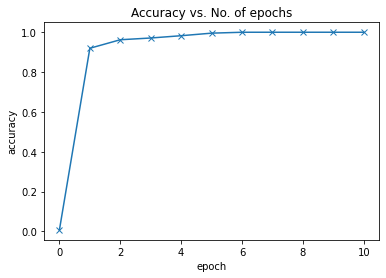

In [24]:
plot_accuracies(history)

# Testing the Model

In [25]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: Apple Braeburn , Predicted: Apple Braeburn


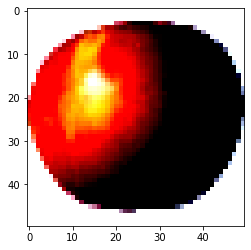

In [26]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Apple Crimson Snow , Predicted: Apple Crimson Snow


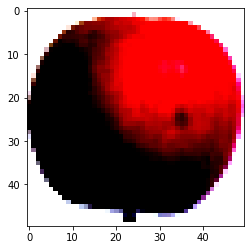

In [27]:
img, label = test_ds[200]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: Apple Golden 2 , Predicted: Apple Golden 2


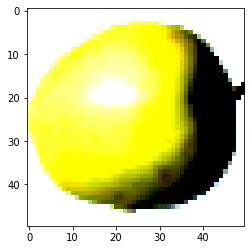

In [28]:
img, label = test_ds[600]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [29]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.2358080893754959, 'val_acc': 0.965282678604126}

So, the final accuracy of this model is 96.5%

In [1]:
!pip install jovian --upgrade --quiet
import jovian
project_name = 'fruits-cnn-project'
jovian.commit(project = project_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/sswaroop46/fruits-cnn-project


<IPython.core.display.Javascript object>